## Android Tap and Sensor Fusion

### Import Libraries

In [29]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os

##### Sensor Data Parser

In [4]:
ls ../Data/SensorInfo/

201711051937  201711061526  201711091951  201711092033


In [66]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

##### Tap Data Parser

In [70]:
ls ../Data/TapInfo/

ml16-141402-201711091951-export.json  ml16-141402-201711092033-export.json


In [82]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

### Load all data

In [87]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [88]:
for filename in glob.glob('../Data/SensorInfo/20171109*'):
    key=filename.split('/')[-1]
    accData[key],gyrData[key],magData[key]=readSensorRecording(filename)

In [89]:
for filename in glob.glob('../Data/TapInfo/ml16-141402-20171109*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033


### Data Integration & Feature Extraction

In [97]:
data=od()

In [261]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        a=acc.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        g=gyr.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        m=mag.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        d=pd.concat([
           pd.DataFrame([row['actionButton']],columns=['target']).T,
            a.apply(mean).rename(lambda x:x+'_mean').T,
            a.apply(var).rename(lambda x:x+'_var'),
            a.apply(skew).rename(lambda x:x+'_skew'),
            a.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            g.apply(mean).rename(lambda x:x+'_mean'),
            g.apply(var).rename(lambda x:x+'_var'),
            g.apply(skew).rename(lambda x:x+'_skew'),
            g.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            m.apply(mean).rename(lambda x:x+'_mean'),
            m.apply(var).rename(lambda x:x+'_var'),
            m.apply(skew).rename(lambda x:x+'_skew'),
            m.apply(kurtosis).rename(lambda x:x+'_kurtosis')]
            ,axis=0).T
        df=df.append([d],ignore_index=True)
    return df

In [262]:
for key in tapData.keys():
        data[key]=fusion(accData[key], gyrData[key], magData[key], tapData[key])

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499
501
503
505
507
510
512
514
516
518
520
522
524
526
528
53

1050
1054
1056
1058
1060
1062
1064
1066
1068
1070
1072
1074
1077
1080
1082
1084
1086
1088
1090
1092
1094
1096
1098
1100
1102
1104
1106
1108
1110
1112
1115
1121
1124
1126
1129
1131
1133
1135
1137
1139
1141
1143
1146
1148
1151
1153
1161
1166
1168
1170
1172
1176
1179
1181
1186
1188
1190
1192
1194
1196
1202
1205
1207
1212
1214
1216
1218
1221
1223
1225
1227
1229
1233
1235
1237
1239
1241
1243
1245
1247
1249
1251
1256
1258
1260
1262
1264
1266
1276
1280
1282
1284
1286
1288
1290
1292
1294
1296
1298
1300
1302
1304
1306
1308
1310
1312
1314
1316
1318
1320
1322
1324
1326
1328
1330
1332
1334
1336
1338
1340
1342
1344
1346
1348
1350
1352
1354
1356
1358
1360
1362
1364
1366
1368
1370
1372
1374
1377
1379
1381
1383
1385
1387
1389
1391
1393
1395
1397
1399
1401
1403
1405
1407
1409
1411
1413
1415
1417
1419
1421
1423
1425
1427
1429
1434
1436
1438
1440
1442
1444
1446
1448
1450
1452
1454
1460
1462
1464
1466
1468
1470
1472
1474
1476
1478
1480
1482
1484
1486
1488
1490
1492
1494
1496
1498
1500
1502
1504
1506
1509


In [272]:
for key in data.keys():
    data[key].to_csv('../Data/Features/'+str(key)+'_features.csv')

In [270]:
def plotSensor(data):
    for key in data.keys():
        data[key].plot(title=key)
    plt.show()

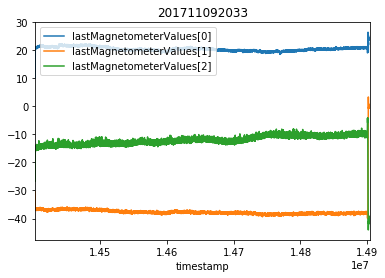

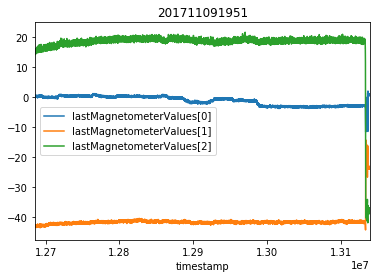

In [65]:
plotSensor(magData)

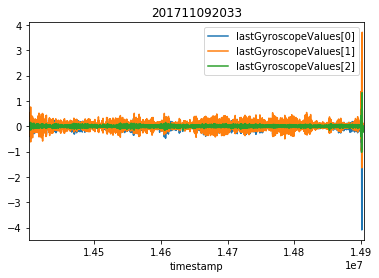

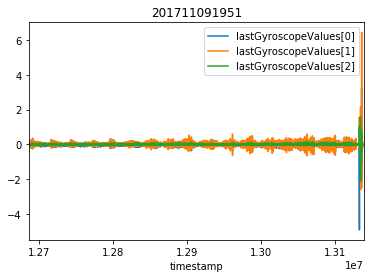

In [64]:
plotSensor(gyrData)